# Squashy Quickstart Demo
This notebook will give you the basic steps to for loading in some graph data, compressing it using Squashy and then demonstrate some ways of visualising the newly generated core graph.


# Loading the Data
The dataset is the Subreddit Hyperlink Network (body) available from [SNAP](https://snap.stanford.edu/data/soc-RedditHyperlinks.html).

Download the dataset from [SNAP](https://snap.stanford.edu/data/soc-RedditHyperlinks.html) and drop the .tsv into the same folder as this notebook.

```
@inproceedings{kumar2018community,
  title={Community interaction and conflict on the web},
  author={Kumar, Srijan and Hamilton, William L and Leskovec, Jure and Jurafsky, Dan},
  booktitle={Proceedings of the 2018 World Wide Web Conference on World Wide Web},
  pages={933--943},
  year={2018},
  organization={International World Wide Web Conferences Steering Committee}
}
```

Below we load the dataset in as chunks, focusing just on the source and target columns and store the edges as tuples.

In [1]:
DATA_PATH = 'soc-redditHyperlinks-body.tsv'

In [2]:
import pandas as pd

edge_tuples = []

with pd.read_csv(DATA_PATH,usecols=['SOURCE_SUBREDDIT','TARGET_SUBREDDIT'], sep='\t', chunksize=10000) as reader:
    for chunk in reader:
        edges = chunk.to_records(index=False).tolist()
        edge_tuples.extend(edges)

In [3]:
edge_tuples[:5]

[('leagueoflegends', 'teamredditteams'),
 ('theredlion', 'soccer'),
 ('inlandempire', 'bikela'),
 ('nfl', 'cfb'),
 ('playmygame', 'gamedev')]

Below we use the provided `DataImporter` class from `Squashy` to load in the tuples. Just loading in the list of edges will generate both the nodes and the relations between them. Duplicate edges are recorded by incrementing a built in `weight` attribute on the newly formed `LINKS_TO` edges.

If you get an `OperationalError` this is likely because Memgraph is not running. Please use Docker to start a Memgraph instance before continuing. If your instance is running, check the address and port number and adjust if necessary.

In [5]:
from squashy import DataImporter

loader = DataImporter(address='localhost', port=7687, node_label='SUBREDDIT', edge_label='LINKS_TO')

The `%time` command is an additional bit of Jupyter magic to measure how long executing the data load takes.

In [6]:
%time loader.load_from_edge_list(edge_tuples)
loader.report()

CPU times: user 232 ms, sys: 44.7 ms, total: 277 ms
Wall time: 5.74 s


'Database currently has 35,776 SUBREDDIT nodes, and 137,821 LINKS_TO edges.'

# Squash Graph!
Now our data is loaded we can squash it into a core graph. Below we use the Squash class to handle the whole process. If preferable you can also use the individual components of Squashy seperately. See the other demo notebook for an example.

Below we show some of the basic arguments when initialising the `Squash` class and additional arguments that can be passed when we instruct it to `squash_graph`.

`max_cores` refers to the maximum number of core nodes we'll allow in our core graph. The squashed core graoh may be smaller than this but never larger.

`k` refers to the 'k' in k-core decomposition and is the minimum number of connections all nodes in the graph must have before we can designate the most connected node a 'core'. Increasing k usually results in less cores overall and reduces the nuance of the representation but playing around with it may yield better results depending on your use case.

`max_hops` refers to how many steps out from the core nodes we want to go when assigning nodes to cores to represent them. 2 hops normally captures > 90% of the nodes in the graph, but it can be set to 3 to increase this, however every step out drastically increases processing time.


In [1]:
from squashy import Squash

squasher = Squash(node_label='SUBREDDIT',relation_label='LINKS_TO', weight_label='weight')
squasher.squash_graph(max_cores=400, k=2, max_hops=2)

# Examine Squashed Graph
Now the graph is squashed we can get its node and edge lists from our `Squash` instance.

In [2]:
edges = squasher.get_core_edge_list()
nodes = squasher.get_core_node_list()

In [3]:
n_squashed_nodes = len(nodes)
n_squashed_edges = len(edges)

In [4]:
n_raw_nodes = squasher.db.node_count('SUBREDDIT')

In [5]:
n_raw_edges = squasher.db.read('MATCH ()-[r:LINKS_TO]-() RETURN count(r) AS n_edges')[0]['n_edges']

In [6]:
print(f"Original Graph size: {n_raw_nodes:,} Nodes and {n_raw_edges:,} Edges")
print(f"Squashed Graph size: {n_squashed_nodes:,} Nodes and {n_squashed_edges:,} Edges")
print(f"Squashed Graph is {(n_squashed_nodes/n_raw_nodes)*100:.2}% of the original nodes & {(n_squashed_edges/n_raw_edges)*100:.2}% of the original edges ")


Original Graph size: 35,776 Nodes and 275,642 Edges
Squashed Graph size: 221 Nodes and 330 Edges
Squashed Graph is 0.62% of the original nodes & 0.12% of the original edges 


# Core Exploration
Squashy just handles the compression and provides you a node and edge list representation of the new core graph. The original data remains in the Memgraph Database so you can always extend your analysis by querying the database manually.

See below for a number of examples of what you might do with your Squashed graoh and to check the quality of the representation.

## Detect Communities

In [7]:
# Demo dependencies
# Needed for the analysis
! pip install netwulf
! pip install wordcloud


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [8]:
import networkx as nx
import pandas as pd
edge_list = pd.DataFrame(edges)
node_list = pd.DataFrame(nodes)

In [9]:
edge_list.head()

,source,target,weight,n_distinct,score
0,raisedbynarcissists,relationships,138,30,66.774194
1,depression,relationships,57,17,28.500000
2,thebluepill,relationships,58,20,37.419355
3,relationship_advice,relationships,137,27,92.475000
4,suicidewatch,relationships,41,21,23.270270


In [10]:
node_list.head()

,id,n_subnodes
0,raisedbynarcissists,62
1,depression,34
2,thebluepill,31
3,relationship_advice,40
4,suicidewatch,37


In [11]:
G = nx.from_pandas_edgelist(edge_list,edge_attr=True, create_using=nx.DiGraph)

node_attr = node_list.set_index('id').rename(columns={'n_subnodes':'size'}).to_dict(orient='index')
nx.set_node_attributes(G, node_attr)

In [12]:
G.number_of_nodes()

221

In [13]:
G.number_of_edges()

330

In [14]:
components = nx.components.connected_components(G.to_undirected())
giant_component = sorted(components, key=len, reverse=True)[0]
len(giant_component)

G = nx.subgraph(G,giant_component)

In [15]:
RESOLUTION = 1.0

communities = nx.algorithms.community.louvain_communities(G,weight='score', resolution=RESOLUTION)
modularity_score = nx.algorithms.community.modularity(G,communities,weight='score', resolution=RESOLUTION)


print(f"N Communities: {len(communities)} - Modularity: {modularity_score:.3}")

N Communities: 22 - Modularity: 0.416


In [16]:
com_to_assign = {}
for i, community in enumerate(communities):
    for member in community:
        com_to_assign[member] = i
com_to_assign

{'theredpill': 0,
 'purplepilldebate': 0,
 'thebluepill': 0,
 'relationships': 1,
 'relationship_advice': 1,
 'raisedbynarcissists': 1,
 'anarchism': 2,
 'anarcho_capitalism': 2,
 'shitstatistssay': 2,
 'socialism': 2,
 'shitliberalssay': 2,
 'thepopcornstand': 3,
 'everysinglethread': 3,
 'bestofoutrageculture': 3,
 'oppression': 3,
 'mensrights': 3,
 'circlebroke': 3,
 'subredditcancer': 3,
 'shitredditsays': 3,
 'justunsubbed': 3,
 'unitedkingdom': 3,
 'subreddit_stats': 3,
 'drama': 3,
 'gamerghazi': 3,
 'kotakuinaction': 3,
 'copypasta': 3,
 'changemyview': 3,
 'subredditdrama': 3,
 'openbroke': 3,
 'circlejerkcopypasta': 3,
 'askhistorians': 4,
 'history': 4,
 'todayilearned': 4,
 'badhistory': 4,
 'assistance': 5,
 'skincareaddiction': 5,
 'makeupaddiction': 5,
 'detroitlions': 6,
 'redskins': 6,
 'patriots': 6,
 'eagles': 6,
 'greenbaypackers': 6,
 'nfl': 6,
 'denverbroncos': 6,
 '49ers': 6,
 'browns': 6,
 'panthers': 6,
 'seahawks': 6,
 'mhocpress': 7,
 'mhoc': 7,
 'modelusgov

In [17]:
sizes = node_list.set_index('id')['n_subnodes'].to_dict()

In [18]:
nx.set_node_attributes(G,sizes,'size')
nx.set_node_attributes(G,com_to_assign,'group')

# Visualising the graph
`Netwulf` generates an interactive visualisation in your browser. Feel free to run the `visualize` method and explore the graph yourself. Just remmeber to press 'Post to Python' to allow Jupyter to resume control.

In [19]:
import netwulf as nw

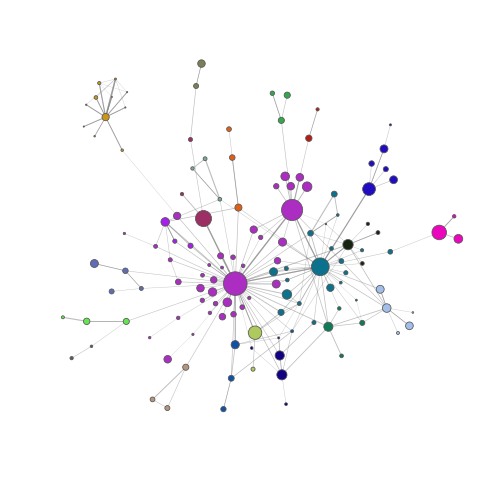

In [20]:
fig, config = nw.visualize(G)

# Community Groups

In [21]:
node_list = node_list.merge(pd.Series(com_to_assign, name='community'), how='left', left_on='id', right_index=True)

In [22]:
# top communities by represented users
node_list.groupby('community')['n_subnodes'].sum().sort_values(ascending=False).head()


community
10.0    5646
3.0     1952
16.0     851
7.0      752
18.0     724
Name: n_subnodes, dtype: int64

In [25]:
# a filter list of the top_n communities used to limit the number of wordclouds we generate below

TOP_N = 20

top_comms =node_list.groupby('community')['n_subnodes'].sum().sort_values(ascending=False).head(TOP_N).index.tolist()


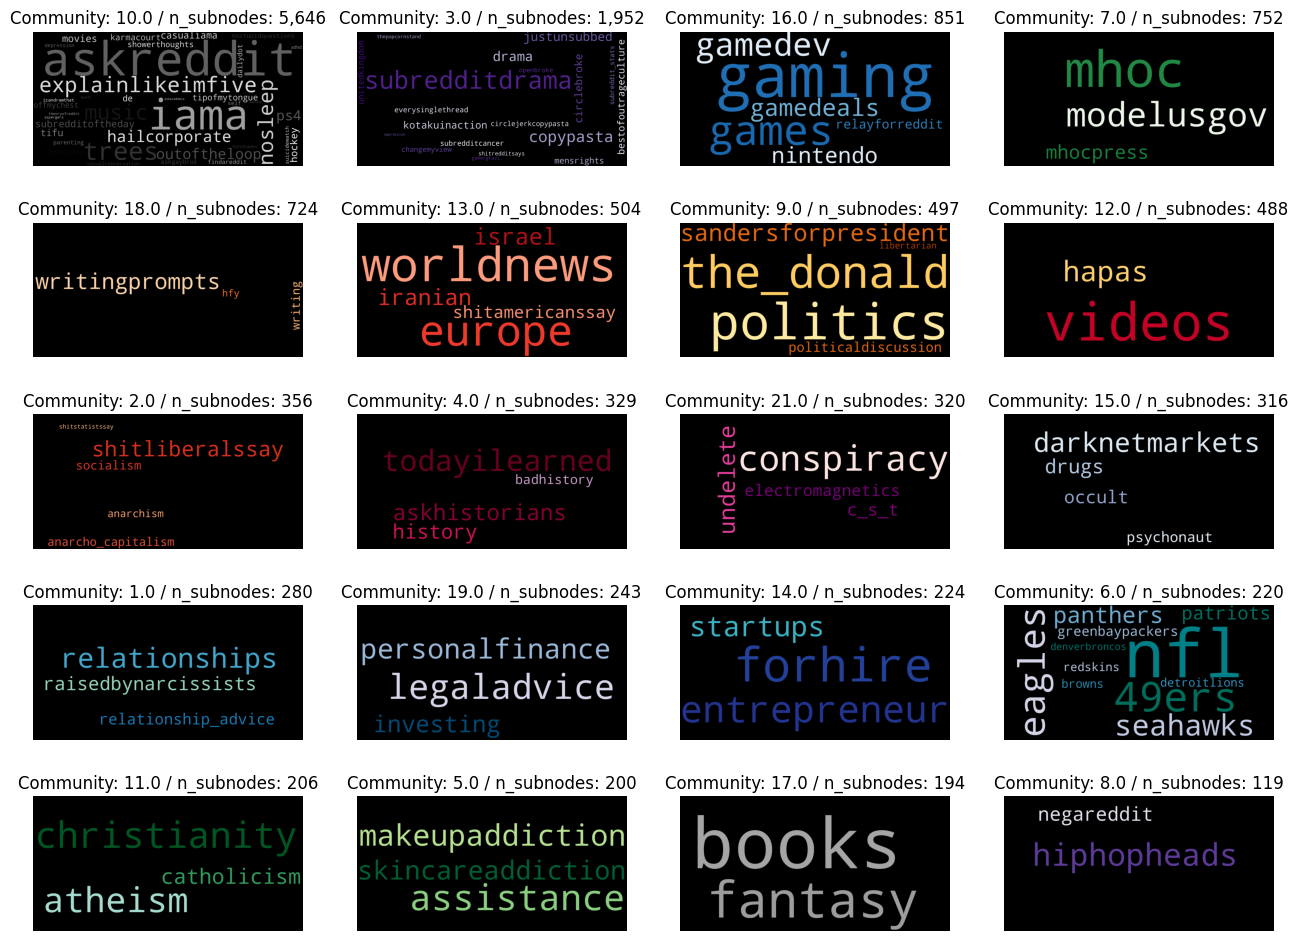

In [26]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

fig, axes = plt.subplots(int(TOP_N/4),4, figsize=(16,12))
axes = axes.flat

colours = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                          'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                          'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']

counts = node_list.groupby('community')['n_subnodes'].sum()

from itertools import cycle
for community, cmap, ax in zip(top_comms, cycle(colours), axes):
    subset = node_list.query(f'community == {community}')
    scores = subset.set_index('id')['n_subnodes'].to_dict()
    wc = WordCloud(colormap=cmap,
                       width=2048,height=1024,
                       background_color='black').generate_from_frequencies(scores)
    ax.imshow(wc)
    ax.axis('off')
    ax.title.set_text(f'Community: {community} / n_subnodes: {counts.loc[community]:,}')

